# noise

In [47]:
import sys,os
import copy
import numpy as np
import sympy as sp
import pylab as py
%matplotlib inline
from tools.tools import load,save
from IPython.display import display, Math, Latex
sp.init_printing()
from sympy.parsing.sympy_parser import parse_expr
lprint=lambda expression: display(Math(sp.latex(expression)))
from tools.bar import BAR
import re
import mpmath as mp
from mpmath import fp

In [48]:
nf   = sp.Symbol('nf')
s   = sp.Symbol('s')
t  = sp.Symbol('t')
u  = sp.Symbol('u')
mu  = sp.Symbol('mu')

s23 = sp.Symbol('s23')
Q   = sp.Symbol('Q')
delta=sp.Function('delta')
Plus1B=sp.Function('Plus1B')
Plus2B=sp.Function('Plus2B')
PolyLOG=sp.Function('PolyLOG')

epsilon=sp.Symbol('epsilon')

B=sp.Symbol('B')
g=sp.Symbol('g')
gp=sp.Symbol('gp')

a=sp.Wild('a')
b=sp.Wild('b')

In [49]:
def load_exp(ch,part):
    L=open('channels/ch%d.%s'%(ch,part)).readlines()
    L=[l.strip() for l in L]
    L=[l.replace(r'&\n','') for l in L]
    expression=''
    for i in range(len(L)):
        l=L[i]
        l=l.replace('\\[Mu]','mu')
        l=l.replace('[','(')
        l=l.replace(']',')')
        l=l.replace('^','**')
        l=l.replace('E4Pi','(EulerGamma - sp.log(4*sp.pi))')
        l=l.replace('PolyLog','PolyLOG')
        l=l.replace('Log','sp.log')
        l=l.replace('Pi','sp.pi')
        l=l.replace('EulerGamma','sp.EulerGamma')
        l=l.replace('Sqrt','sp.sqrt')
        l=l.rstrip('\\')
        l=l.replace('\"','')
        l=l.strip()
        if l!='': expression+=l
    exec 'exp=%s'%expression
    return exp

In [50]:
chn=1
exp1=load_exp(chn,'regular')
exp2=load_exp(chn,'delta')
exp3=load_exp(chn,'plus1B')
exp4=load_exp(chn,'plus2B')

In [51]:
def gen_ps(xi,s23val):
    ps={}
    ps['x']=0.1326
    ps['z']=0.4
    ps['Q']=5.3**0.5
    ps['qT']=3.0
    ps['s23']=s23val
    ps['xi']=xi
    ps['xh']=ps['x']/ps['xi']
    ps['zh']=(-ps['s23']+ps['Q']**2*(1-ps['xh'])/ps['xh'])/(ps['qT']**2+ps['Q']**2*(1-ps['xh'])/ps['xh'])
    ps['zeta']=ps['z']/ps['zh']
    ps['s']=(1-ps['xh'])/ps['xh']*ps['Q']**2
    ps['t']=-(1-ps['zh'])*ps['Q']**2-ps['zh']*ps['qT']**2
    ps['nf']=4.0
    ps['B']=ps['Q']**2*(1/ps['xh']-1)*(1-ps['z'])-ps['z']*ps['qT']**2
    return ps

def evaluate(exp,xi,s23val,verb=False):
    ps=gen_ps(xi,s23val)
    test=exp.subs(g,1.)
    test=test.subs(Q,ps['Q'])
    test=test.subs(s23,ps['s23'])
    test=test.subs(s,ps['s'])
    test=test.subs(t,ps['t'])
    test=test.subs(mu,ps['Q'])
    test=test.subs(sp.EulerGamma,np.euler_gamma)
    test=test.subs(B,ps['B'])
    test=test.subs(nf,ps['nf'])
    test=test.subs(sp.pi,np.pi)
    if verb:
        print ps['x']
        print ps['z']
        print ps['Q']
        print ps['qT']
        print ps['s23']
        print ps['xi']
        print ps['xh']
        print ps['zh']
        print ps['zeta']
        print ps['s']
        print ps['t']
        print ps['B']
    return test

In [52]:
def simplify(exp):
    factors=exp.as_ordered_factors()
    terms  =exp.as_ordered_terms()
    if len(terms)>1: 
        result=sp.S(0)
        for term in terms:
            result+=simplify(term)
        return result
    elif len(factors)>1:
        result=sp.S(1)
        for factor in factors:
            if factor.is_real==True:
                factor=sp.nsimplify(factor)
            result*=simplify(factor)
        return result        
    elif len(terms)==1 and len(factors)==1:
        return exp.simplify()
        
# sexp3=simplify(exp3)
# sexp3=simplify(sexp3)
# sexp3=sexp3.subs(s23,0)
# sexp3=simplify(sexp3)

## study the integrand as a function of $\xi$ for $s_{23}=10^{-10}$

proc [43/44]

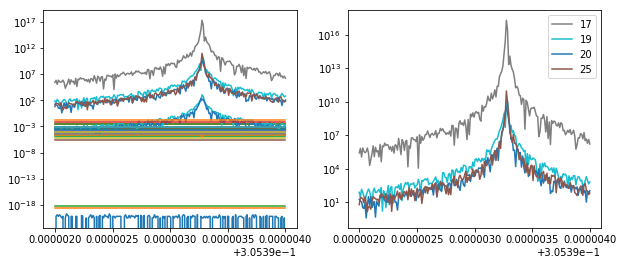

In [53]:
nrows,ncols=1,2
fig = py.figure(figsize=(ncols*5,nrows*4))
ax1=py.subplot(nrows,ncols,1)
ax2=py.subplot(nrows,ncols,2)

zero=1e-15
lexp3=exp3.as_ordered_terms()

xi=np.linspace(0.305392,0.305394,200)
bar=BAR('proc',len(lexp3))
for i in range(len(lexp3)):
    noise=[]
    for _ in xi:
        val=sp.N(evaluate(lexp3[i].replace(PolyLOG(a,b),sp.polylog(a,b)),_,zero))
        noise.append(np.abs(val))     
    p,=ax1.plot(xi,noise,label=str(i))
    if np.any(noise)>3e-2: ax2.plot(xi,noise,c=p.get_color(),label=str(i))
    bar.next()
ax1.semilogy()
ax2.semilogy()
ax2.legend(loc='best')

## study most problematic term

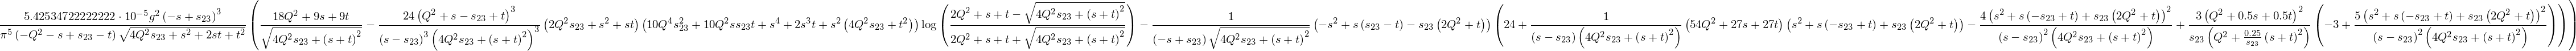

In [9]:
exp3_17=lexp3[17]
exp3_17

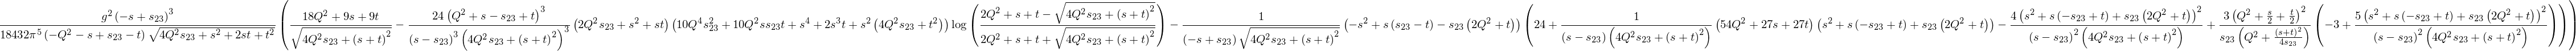

In [64]:
exp3_17=sp.nsimplify(exp3_17)
exp3_17

In [71]:
print str(exp3_17).replace('**','^')

g^2*(-s + s23)^3*((18*Q^2 + 9*s + 9*t)/sqrt(4*Q^2*s23 + (s + t)^2) - 24*(2*Q^2*s23 + s^2 + s*t)*(Q^2 + s - s23 + t)^3*(10*Q^4*s23^2 + 10*Q^2*s*s23*t + s^4 + 2*s^3*t + s^2*(4*Q^2*s23 + t^2))*log((2*Q^2 + s + t - sqrt(4*Q^2*s23 + (s + t)^2))/(2*Q^2 + s + t + sqrt(4*Q^2*s23 + (s + t)^2)))/((s - s23)^3*(4*Q^2*s23 + (s + t)^2)^3) - (-s^2 + s*(s23 - t) - s23*(2*Q^2 + t))*(24 + (54*Q^2 + 27*s + 27*t)*(s^2 + s*(-s23 + t) + s23*(2*Q^2 + t))/((s - s23)*(4*Q^2*s23 + (s + t)^2)) - 4*(s^2 + s*(-s23 + t) + s23*(2*Q^2 + t))^2/((s - s23)^2*(4*Q^2*s23 + (s + t)^2)) + 3*(-3 + 5*(s^2 + s*(-s23 + t) + s23*(2*Q^2 + t))^2/((s - s23)^2*(4*Q^2*s23 + (s + t)^2)))*(Q^2 + s/2 + t/2)^2/(s23*(Q^2 + (s + t)^2/(4*s23))))/((-s + s23)*sqrt(4*Q^2*s23 + (s + t)^2)))/(18432*pi^5*(-Q^2 - s + s23 - t)*sqrt(4*Q^2*s23 + s^2 + 2*s*t + t^2))


proc [6/7]

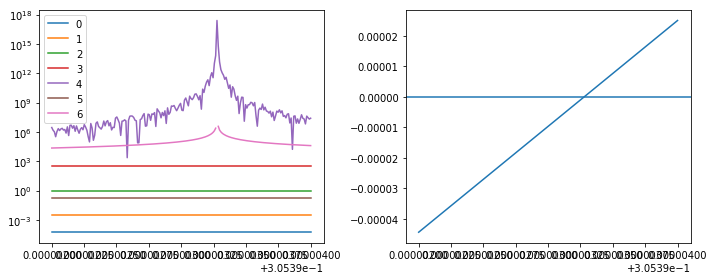

In [42]:
nrows,ncols=1,2
fig = py.figure(figsize=(ncols*5,nrows*4))
ax=py.subplot(nrows,ncols,1)

zero=1e-19
lexp3_17=exp3_17.as_ordered_factors()

xi=np.linspace(0.305392,0.305394,200)
bar=BAR('proc',len(lexp3_17))
for i in range(len(lexp3_17)):
    noise=[]
    for _ in xi:
        val=sp.N(evaluate(lexp3_17[i].replace(PolyLOG(a,b),sp.polylog(a,b)),_,zero))
        noise.append(np.abs(val))     
    ax.plot(xi,noise,label=str(i))
    bar.next()
ax.semilogy()
ax.legend(loc='best')

ax=py.subplot(nrows,ncols,2)
xi=np.linspace(0.305392,0.305394,100)
noise=[]
for _ in xi:
    val=sp.N(evaluate(s+t,_,zero))
    noise.append(val)     
ax.plot(xi,noise)
ax.axhline(0)
py.tight_layout()

## study most problematic factor 

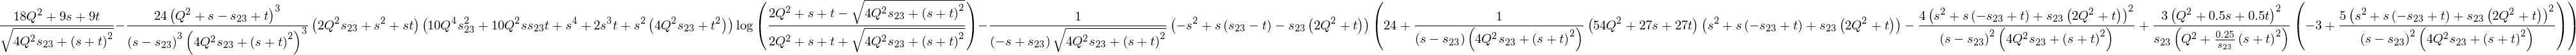

In [13]:
exp3_17_4=lexp3_17[4]
exp3_17_4

proc [2/3]

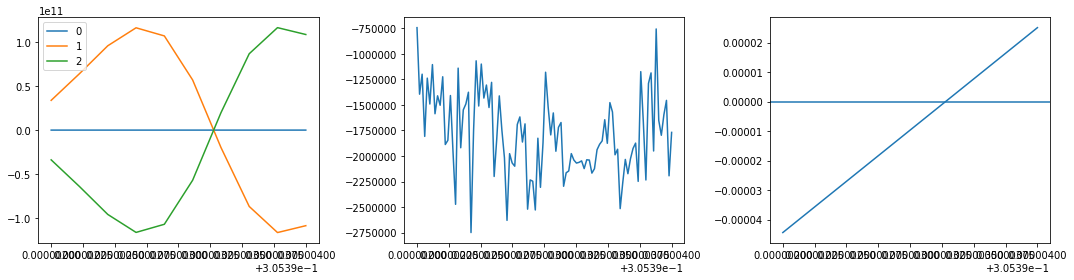

In [45]:
nrows,ncols=1,3
fig = py.figure(figsize=(ncols*5,nrows*4))
ax=py.subplot(nrows,ncols,1)

lexp3_17_4=exp3_17_4.as_ordered_terms()

zero=1e-10

xi=np.linspace(0.305392,0.305394,10)
bar=BAR('proc',len(lexp3_17_4))
for i in range(len(lexp3_17_4)):
    noise=[]
    for _ in xi:
        val=sp.N(evaluate(lexp3_17_4[i].replace(PolyLOG(a,b),sp.polylog(a,b)),_,zero))
        noise.append(val)     
    ax.plot(xi,noise,label=str(i))
    bar.next()
#ax.semilogy()
ax.legend(loc='best')

ax=py.subplot(nrows,ncols,2)
xi=np.linspace(0.305392,0.305394,100)
noise=[]
for _ in xi:
    val1=sp.N(evaluate(lexp3_17_4[1].replace(PolyLOG(a,b),sp.polylog(a,b)),_,zero))
    val2=sp.N(evaluate(lexp3_17_4[2].replace(PolyLOG(a,b),sp.polylog(a,b)),_,zero))

    noise.append(val1+val2)     
ax.plot(xi,noise)

ax=py.subplot(nrows,ncols,3)
xi=np.linspace(0.305392,0.305394,100)
noise=[]
for _ in xi:
    val=sp.N(evaluate(s+t,_,zero))
    noise.append(val)     
ax.plot(xi,noise)
ax.axhline(0)
py.tight_layout()

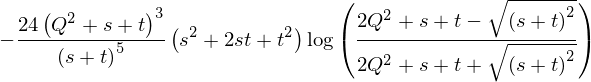

In [50]:
test1=lexp3_17_4[1].subs(s23,0).simplify()
test1

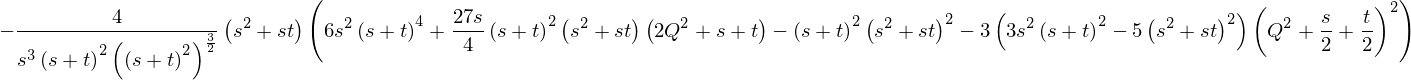

In [59]:
test2=sp.nsimplify(lexp3_17_4[2].simplify().subs(s23,0))
test2

In [60]:
print test2

-4*(s**2 + s*t)*(6*s**2*(s + t)**4 + 27*s*(s + t)**2*(s**2 + s*t)*(2*Q**2 + s + t)/4 - (s + t)**2*(s**2 + s*t)**2 - 3*(3*s**2*(s + t)**2 - 5*(s**2 + s*t)**2)*(Q**2 + s/2 + t/2)**2)/(s**3*(s + t)**2*((s + t)**2)**(3/2))


In [63]:
sp.limit((test2+test1).subs(s+t,epsilon),epsilon,0)

In [62]:
sp.limit(test1.subs(s+t,epsilon),epsilon,0)

proc [9/10]

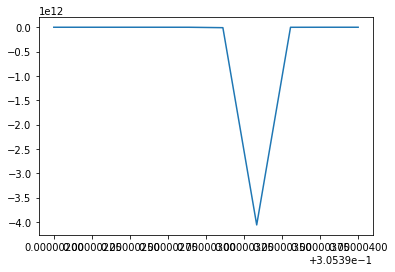

In [61]:
xi=np.linspace(0.305392,0.305394,10)
ax=py.subplot(111)
bar=BAR('proc',len(xi))
noise=[]
for _ in xi:

    exp3_val=sp.N(evaluate(exp3.replace(PolyLOG(a,b),sp.polylog(a,b)),_,0.1))
    #exp30_val=sp.N(evaluate(sexp3.replace(PolyLOG(a,b),sp.polylog(a,b)),_,0))

    noise.append(exp3_val-exp30_val)
    bar.next()
ax.plot(xi,noise)


proc [99/100]

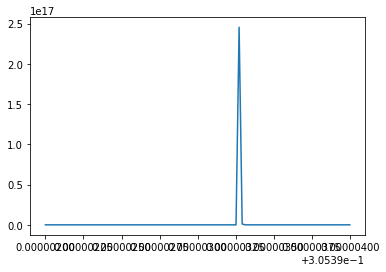

In [53]:
xi=np.linspace(0.305392,0.305394,100)
ax=py.subplot(111)
bar=BAR('proc',len(xi))
noise=[]
for _ in xi:
    val=sp.N(evaluate(sexp3.replace(PolyLOG(a,b),sp.polylog(a,b)),_,1e-10))
    noise.append(val)
    bar.next()
ax.plot(xi,noise)


proc [33/38]

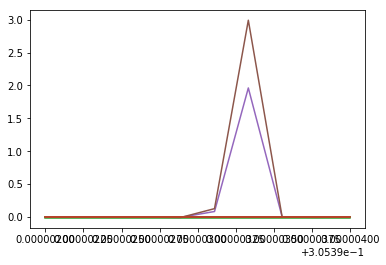

In [32]:
lprint(lexp3[17])

<IPython.core.display.Math object>

In [37]:
lexp317 = lexp3[17].as_ordered_factors()
for i in range(len(lexp317)): 
    print i,lexp317[i]

0 5.42534722222222e-5
1 pi**(-5)
2 g**2
3 (-s + s23)**3
4 (18*Q**2 + 9*s + 9*t)/sqrt(4*Q**2*s23 + (s + t)**2) - 24*(2*Q**2*s23 + s**2 + s*t)*(Q**2 + s - s23 + t)**3*(10*Q**4*s23**2 + 10*Q**2*s*s23*t + s**4 + 2*s**3*t + s**2*(4*Q**2*s23 + t**2))*log((2*Q**2 + s + t - sqrt(4*Q**2*s23 + (s + t)**2))/(2*Q**2 + s + t + sqrt(4*Q**2*s23 + (s + t)**2)))/((s - s23)**3*(4*Q**2*s23 + (s + t)**2)**3) - (-s**2 + s*(s23 - t) - s23*(2*Q**2 + t))*(24 + (54*Q**2 + 27*s + 27*t)*(s**2 + s*(-s23 + t) + s23*(2*Q**2 + t))/((s - s23)*(4*Q**2*s23 + (s + t)**2)) - 4*(s**2 + s*(-s23 + t) + s23*(2*Q**2 + t))**2/((s - s23)**2*(4*Q**2*s23 + (s + t)**2)) + 3*(-3 + 5*(s**2 + s*(-s23 + t) + s23*(2*Q**2 + t))**2/((s - s23)**2*(4*Q**2*s23 + (s + t)**2)))*(Q**2 + 0.5*s + 0.5*t)**2/(s23*(Q**2 + 0.25*(s + t)**2/s23)))/((-s + s23)*sqrt(4*Q**2*s23 + (s + t)**2))
5 1/(-Q**2 - s + s23 - t)
6 1/sqrt(4*Q**2*s23 + s**2 + 2*s*t + t**2)


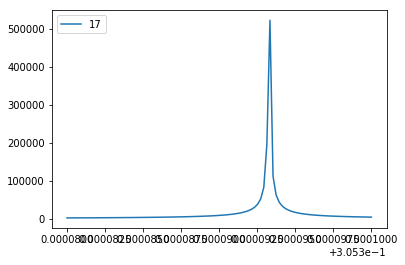

In [107]:
xi=np.linspace(0.30538,0.3054,100)
ax=py.subplot(111)
noise=[]
term=lexp317[6]
for _ in xi:
    val=sp.N(evaluate((term).replace(PolyLOG(a,b),sp.polylog(a,b)),_,1e-20))
    noise.append(val)
ax.plot(xi,noise,label=str(i))

ax.legend(loc=2)

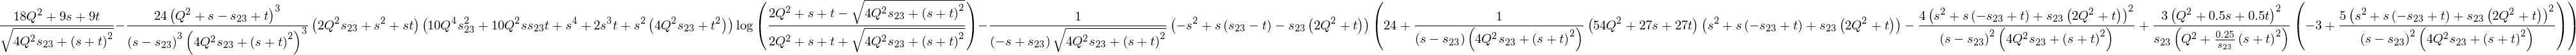

In [64]:
lexp317[4]

In [57]:
lexp3174=lexp317[4].as_ordered_terms()
for i in range(len(lexp3174)): 
    print 
    print i,lexp3174[i]


0 (18*Q**2 + 9*s + 9*t)/sqrt(4*Q**2*s23 + (s + t)**2)

1 -24*(2*Q**2*s23 + s**2 + s*t)*(Q**2 + s - s23 + t)**3*(10*Q**4*s23**2 + 10*Q**2*s*s23*t + s**4 + 2*s**3*t + s**2*(4*Q**2*s23 + t**2))*log((2*Q**2 + s + t - sqrt(4*Q**2*s23 + (s + t)**2))/(2*Q**2 + s + t + sqrt(4*Q**2*s23 + (s + t)**2)))/((s - s23)**3*(4*Q**2*s23 + (s + t)**2)**3)

2 -(-s**2 + s*(s23 - t) - s23*(2*Q**2 + t))*(24 + (54*Q**2 + 27*s + 27*t)*(s**2 + s*(-s23 + t) + s23*(2*Q**2 + t))/((s - s23)*(4*Q**2*s23 + (s + t)**2)) - 4*(s**2 + s*(-s23 + t) + s23*(2*Q**2 + t))**2/((s - s23)**2*(4*Q**2*s23 + (s + t)**2)) + 3*(-3 + 5*(s**2 + s*(-s23 + t) + s23*(2*Q**2 + t))**2/((s - s23)**2*(4*Q**2*s23 + (s + t)**2)))*(Q**2 + 0.5*s + 0.5*t)**2/(s23*(Q**2 + 0.25*(s + t)**2/s23)))/((-s + s23)*sqrt(4*Q**2*s23 + (s + t)**2))


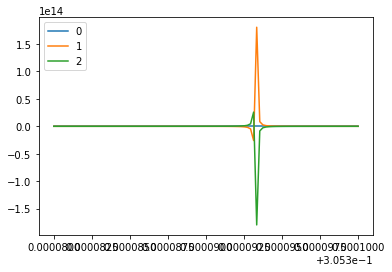

In [85]:
xi=np.linspace(0.30538,0.3054,100)
ax=py.subplot(111)
zero=1e-15

noise=[]
term=lexp3174[0]
for _ in xi:
    val=sp.N(evaluate((term).replace(PolyLOG(a,b),sp.polylog(a,b)),_,zero))
    noise.append(val)
ax.plot(xi,noise,label=str(0))

noise=[]
term=lexp3174[1]
for _ in xi:
    val=sp.N(evaluate((term).replace(PolyLOG(a,b),sp.polylog(a,b)),_,zero))
    noise.append(val)
ax.plot(xi,noise,label=str(1))

noise=[]
term=lexp3174[2]
for _ in xi:
    val=sp.N(evaluate((term).replace(PolyLOG(a,b),sp.polylog(a,b)),_,zero))
    noise.append(val)
ax.plot(xi,noise,label=str(2))

ax.legend(loc=2)

In [95]:
test1=lexp3174[1].subs(s23,0)
test2=lexp3174[2].simplify().subs(s23,0)

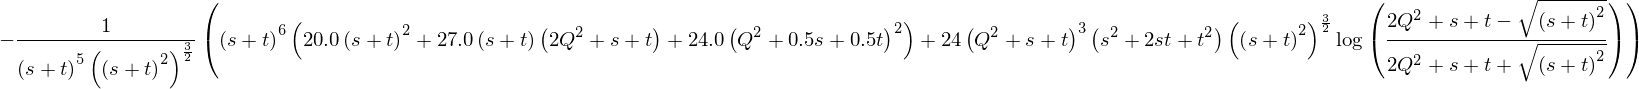

In [110]:
test12=test1+test2
test12=test12.simplify()
test12

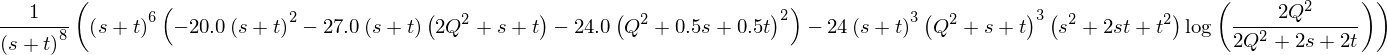

In [120]:
test12=sp.powdenest(test12,force=True)
test12

In [132]:
tot=1
for i in range(6):
    if i!=4: tot*=lexp317[i]
    else:  tot*=(lexp3174[0]+test12)

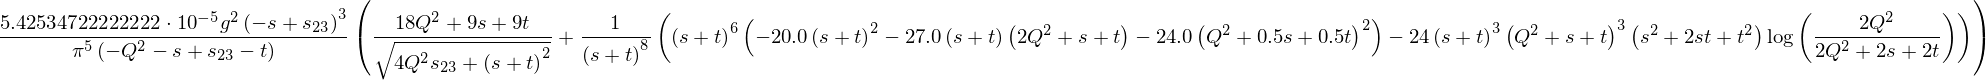

In [133]:
tot

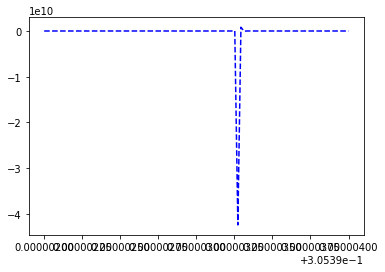

In [134]:
xi=np.linspace(0.305392,0.305394,100)
ax=py.subplot(111)

# noise=[]
# for _ in xi:
#     val=sp.N(evaluate((1/(s+t)**2).replace(PolyLOG(a,b),sp.polylog(a,b)),_,1e-8))
#     noise.append(val)
# ax.plot(xi,noise,'r-',label=str(0))

noise=[]
for _ in xi:
    val=sp.N(evaluate((tot).replace(PolyLOG(a,b),sp.polylog(a,b)),_,0))
    noise.append(val)
ax.plot(xi,noise,'b--',label=str(0))

#ax.set_ylim(0,10)


In [5]:
def get_s23zero_limit(exp):

    lexp=(exp.subs(s23,0)).as_ordered_terms()
    new_exp=0
    bar=BAR("proceesing",len(lexp))
    for term in lexp:
        dummy1=1
        for f in term.as_ordered_factors():
            dummy2=0
            for ft in f.as_ordered_terms():
                dummy2+=sp.powdenest(ft,force=True).simplify()
            dummy1*=dummy2
        new_exp+=dummy1
        bar.next()
    bar.finish()
    
    lexp=new_exp.as_ordered_terms()
    new_exp=sp.S(0)
    for term in lexp:
        if evaluate(term,0,verb=False)==0: continue
        new_exp+=term.replace(sp.log(a),sp.log(sp.Abs(a)))
    
    return new_exp

In [6]:
def get_s23zero_limit2(exp):

    lexp=exp.as_ordered_terms()
    new_exp=0
    bar=BAR("proceesing",len(lexp))
    for term in lexp:
        dummy1=1
        for f in term.as_ordered_factors():
            dummy2=0
            for ft in f.as_ordered_terms():
                if 'zoo' in str(ft.subs(s23,0)):
                    dummy2+=ft.simplify()
                else: 
                    dummy2+=ft
            dummy1*=dummy2
        new_exp+=dummy1.subs(s23,0)
        bar.next()
    bar.finish()
    
    lexp=new_exp.as_ordered_terms()
    new_exp=sp.S(0)
    for term in lexp:
        #if evaluate(term,0,verb=False)==0: continue
        new_exp+=term.replace(sp.log(a),sp.log(sp.Abs(a)))
    return new_exp

In [10]:
print sp.N(evaluate(exp2.replace(PolyLOG(a,b),sp.polylog(a,b)),0.00000001))
#print sp.N(evaluate(exp20.replace(PolyLOG(a,b),sp.polylog(a,b)),0.000000001))


1.98147666859023


In [188]:
lexp2=exp2.as_ordered_terms()

In [195]:
for term in lexp2:
    term0=term.subs(s23,0)
    if 'zoo' in str(sp.N(evaluate(term0.replace(PolyLOG(a,b),sp.polylog(a,b)),0.000001))):
        for f in term.as_ordered_factors():
            f0=f.subs(s23,0)
            if 'zoo' in str(sp.N(evaluate(f0.replace(PolyLOG(a,b),sp.polylog(a,b)),0.000001))):
                for t in f.as_ordered_terms():
                    t0=t.subs(s23,0)
                    if 'zoo' in str(sp.N(evaluate(t0.replace(PolyLOG(a,b),sp.polylog(a,b)),0.000001))):
                        print t

((18*Q**2 + 9*s + 9*t)/sqrt(4*Q**2*s23 + (s + t)**2) - 24*(2*Q**2*s23 + s**2 + s*t)*(Q**2 + s - s23 + t)**3*(10*Q**4*s23**2 + 10*Q**2*s*s23*t + s**4 + 2*s**3*t + s**2*(4*Q**2*s23 + t**2))*log((2*Q**2 + s + t - sqrt(4*Q**2*s23 + (s + t)**2))/(2*Q**2 + s + t + sqrt(4*Q**2*s23 + (s + t)**2)))/((s - s23)**3*(4*Q**2*s23 + (s + t)**2)**3) - (-s**2 + s*(s23 - t) - s23*(2*Q**2 + t))*(24 + (54*Q**2 + 27*s + 27*t)*(s**2 + s*(-s23 + t) + s23*(2*Q**2 + t))/((s - s23)*(4*Q**2*s23 + (s + t)**2)) - 4*(s**2 + s*(-s23 + t) + s23*(2*Q**2 + t))**2/((s - s23)**2*(4*Q**2*s23 + (s + t)**2)) + 3*(-3 + 5*(s**2 + s*(-s23 + t) + s23*(2*Q**2 + t))**2/((s - s23)**2*(4*Q**2*s23 + (s + t)**2)))*(Q**2 + 0.5*s + 0.5*t)**2/(s23*(Q**2 + 0.25*(s + t)**2/s23)))/((-s + s23)*sqrt(4*Q**2*s23 + (s + t)**2)))*(-0.0029296875*log(mu)/pi**5 - 0.0029296875*log(2)/pi**5 - 0.00146484375*log(pi)/pi**5 - 0.00146484375/pi**5 + 0.00146484375*EulerGamma/pi**5)
0.00146484375*((18*Q**2 + 9*s + 9*t)/sqrt(4*Q**2*s23 + (s + t)**2) - 24*(2*Q*

In [187]:
lexp20=exp20.as_ordered_terms()
for term in lexp20:
    eterm=sp.N(evaluate(term.replace(PolyLOG(a,b),sp.polylog(a,b)),0.000001))
    if eterm==sp.zoo: 
        for f in term.as_ordered_factors():
            if sp.N(evaluate(f.replace(PolyLOG(a,b),sp.polylog(a,b)),0.000001))==sp.zoo:
                for ff in f.as_ordered_terms():
                    if sp.N(evaluate(ff.replace(PolyLOG(a,b),sp.polylog(a,b)),0.00001))==sp.zoo:
                        lprint(ff)
                        print sp.N(evaluate(ff.replace(PolyLOG(a,b),sp.polylog(a,b)),0.00001))

<IPython.core.display.Math object>

zoo


In [183]:
sp.polylog(2,1)

In [116]:
exp20=get_s23zero_limit2(exp2)

proceesing [58/58]


In [164]:
print sp.N(evaluate(exp20.replace(PolyLOG(a,b),sp.polylog(a,b)),0.000001))


zoo


In [159]:
test=exp20.subs(g,1)
test=test.subs(s,10.0)
test=test.subs(Q,5.0)
#test=test.subs(t,-1.)
#test=test.subs(sp.pi,3.14)
ltest=test.as_ordered_terms()
for term in ltest:
    print "="*50
    print term
    print ":"*50
    print term.subs(sp.pi,np.pi)

-t**3*(-4.0*(-0.00439453125*t**3*(t + 10.0)**5*(t + 35.0)**3*(4*PolyLOG(2, 2*sqrt((t + 10.0)**2)/(t + sqrt((t + 10.0)**2) + 60.0)) + log(Abs((t - sqrt((t + 10.0)**2) + 60.0)/(t + sqrt((t + 10.0)**2) + 60.0)))**2)*((t + 10.0)**2)**(9/2) - 0.0001220703125*t*(t + 10.0)**14*(27.0*t + 1620.0)*(3*t**2*(t + 10.0)**2 - 7*(t**2 + 10.0*t)**2) - 0.00439453125*(0.5*t + 30.0)**2*(t + 10.0)**12*(t**2 + 10.0*t)*(9*t**2*(t + 10.0)**2 - 13*(t**2 + 10.0*t)**2) + 0.00048828125*(t + 10.0)**14*(t**2 + 10.0*t)*(39*t**2*(t + 10.0)**2 - 8*(t**2 + 10.0*t)**2))/(pi**5*t**3*(t + 10.0)**2*((t + 10.0)**2)**(15/2)) - 4.0*(6.0*t**3*(t + 10.0)**13*(t + 35.0)**3*log(Abs((t - sqrt((t + 10.0)**2) + 60.0)/(t + sqrt((t + 10.0)**2) + 60.0))) - 2.25*t**3*(t + 10.0)**2*(t + 60.0)*((t + 10.0)**2)**(13/2) - (t**2 + 10.0*t)*(-6.0*t**2*(t + 10.0)**4 - 6.75*t*(t + 10.0)**2*(t + 60.0)*(t**2 + 10.0*t) + (0.5*t + 30.0)**2*(9*t**2*(t + 10.0)**2 - 15*(t**2 + 10.0*t)**2) + (t + 10.0)**2*(t**2 + 10.0*t)**2)*((t + 10.0)**2)**(11/2))*(0.0

In [128]:
exp30=get_s23zero_limit2(exp3)

proceesing [44/44]


In [130]:
#print exp30

In [131]:
exp40=get_s23zero_limit2(exp4)

proceesing [14/14]


In [132]:
print exp40

0.209635416666667*g**2*s/pi**5 + 0.00130208333333333*g**2*s*(Q**2 + s + t)/(pi**5*(-Q**2 - s - t)) + 0.00130208333333333*g**2*(Q**4 + 2*Q**2*s + 2*Q**2*t + s**2 + 2*s*t + t**2)/(pi**5*(Q**2 + s + t)) - 0.005859375*g**2*(Q**2 + s + t)*(3*Q**2 + 7*s + 5*t)/(pi**5*(-Q**2 - s - t)) - 0.00130208333333333*g**2*(Q**6 + 2*Q**4*s + 4*Q**4*t + Q**2*s**2 + 8*Q**2*s*t + 5*Q**2*t**2 + 4*s**2*t + 6*s*t**2 + 2*t**3)/(pi**5*t*(Q**2 + s + t)) + 0.005859375*g**2*(3*Q**2 + 3*s + 5*t)*(Q**2*t + s*t + t**2)/(pi**5*t*(-Q**2 - s - t)) + 0.00130208333333333*g**2*(Q**2 + t)*(Q**2*s + s**2 + s*t)/(pi**5*s*t)


In [33]:
gen_code(chn,exp1,exp20,exp3,exp30,exp4,exp40)

In [83]:
print sp.N(evaluate(exp1,0.2))
#print sp.N(evaluate(exp4.replace(PolyLOG(a,b),sp.polylog(a,b)),0.0001))
#print sp.N(evaluate(exp1B.replace(PolyLOG(a,b),sp.polylog(a,b)),1e-10))

0.358702070396228
